In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import shap
shap.initjs()
import warnings
warnings.simplefilter('ignore')

In [2]:
fao_data = pd.read_csv("~/Documents/Kaleb-Bsc thesis/Crop yield and soil/datasets/latest0705.csv", index_col='Unnamed: 0')

fao_data

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Plant Growth Regulators-1,Plant Growth Regulators-2,Rodenticides – Other-1,Rodenticides – Other-2,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.0,0.0,0.0,Mixed grain,-5.8863,0.0,0.0,0.0,0.0,0.0,...,0.0,144.0,0.0,6.0,0.0,-84.0,0.0,4.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Oats,0.8941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Rye,0.9290,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Triticale,0.4421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1


In [3]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals'],
      dtype=object)

In [4]:
shap_df = pd.DataFrame()

['Autumn', 'Spring', 'Summer']


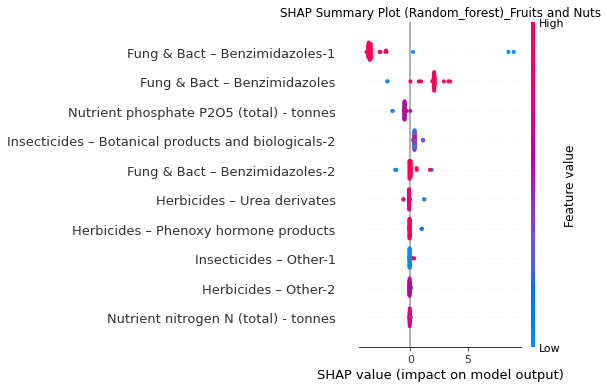

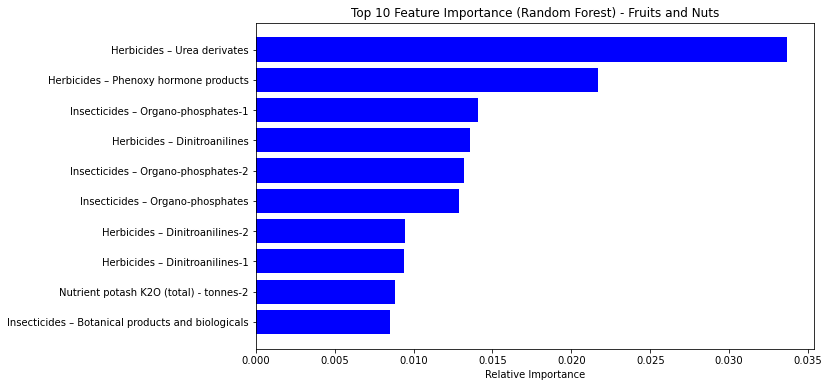

['Fall', 'Spring', 'Summer', 'Winter']


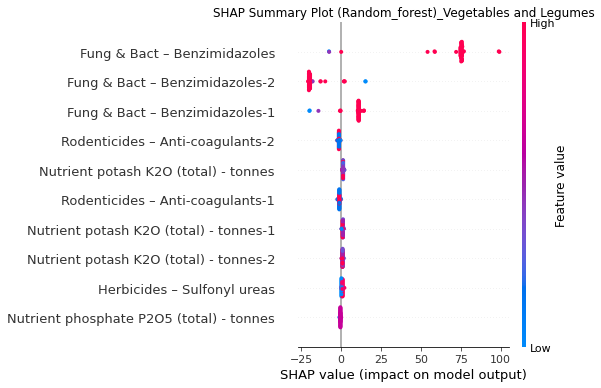

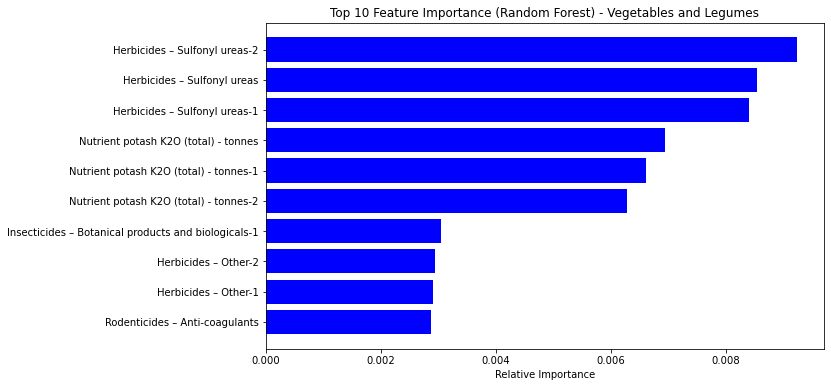

['Autumn', 'Spring']


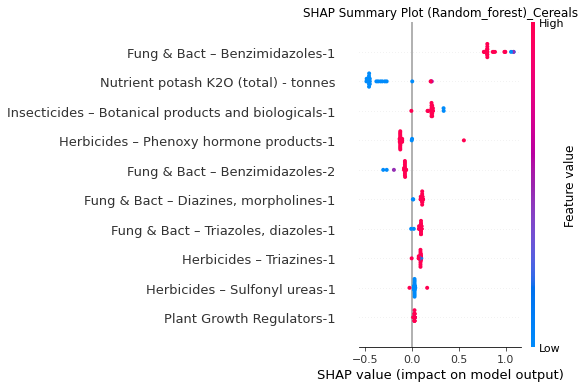

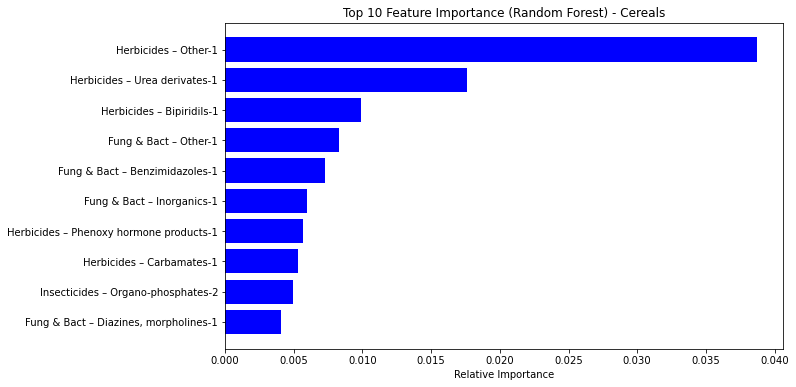

In [25]:
scaler = MinMaxScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Crop_season"]], prefix='', prefix_sep='')
    encoded_df = encoded_df.drop(encoded_df.columns[-1], axis=1)
    print(list(encoded_df.columns))

    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category", "Crop_season"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)

    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)

    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)
    regressor = RandomForestRegressor(n_estimators=500, random_state=42)
    regressor.fit(x_train, y_train)

    # Prediction of new values
    y_pred = regressor.predict(x_test)
    importances = regressor.feature_importances_
    vals = list(encoded_df.columns) + ["Yield(tonnes/ha)-2", "Yield(tonnes/ha)-1"]
    selected_features = list(x.columns)
    for i in vals:
        selected_features.remove(i)
     # Calculate feature importances for selected features
    selected_feature_indices = [i for i, feature_name in enumerate(x_train.columns) if feature_name in selected_features]
    selected_feature_importances = importances[selected_feature_indices]
    selected_features = [feature for feature in selected_features if feature not in vals]

        #shap implementation
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(x_test.iloc[:, selected_feature_indices], check_additivity=False) # Use selected features from the test set
    plt.title("SHAP Summary Plot (Random_forest)" + "_" + cat) 
    shap.summary_plot(shap_values, x_test.iloc[:, selected_feature_indices], max_display=10)# Use selected features for plotting
    plt.show()
    


    

    # Plot the feature importances for selected features
    indices = np.argsort(selected_feature_importances)[-10:]  # Select the indices of the top 10 features
    features = selected_features
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importance (Random Forest) - ' + cat)
    plt.barh(range(len(indices)), selected_feature_importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()


In [6]:
shap_values = pd.DataFrame(explainer.shap_values(x_test), columns= x_test.columns)
shap_values

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,"Fung & Bact – Triazoles, diazoles",Herbicides – Amides,...,Herbicides – Bipiridils-3,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Herbicides – Sulfonyl ureas-3,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2,Rodenticides – Anti-coagulants-3,Spring,Summer,Year-Round
0,-3.009745e-04,-0.000025,0.000207,0.000227,0.000203,0.000674,0.000583,0.000883,0.000310,-0.000143,...,0.000162,0.000307,0.010045,0.000127,0.006014,0.009285,0.007840,0.589879,0.037574,-0.020995
1,-4.069651e-05,-0.000311,-0.000013,0.000027,0.000074,-0.000158,-0.000073,0.000106,-0.000061,-0.000037,...,0.000190,0.000167,0.001389,0.000132,0.015516,0.015027,0.013716,0.110091,0.003797,-0.021322
2,-1.901865e-05,-0.000231,0.000119,0.000066,0.000075,-0.000005,0.000046,0.000134,-0.000015,-0.000032,...,0.000155,0.002786,0.003627,0.000138,0.000932,0.002313,0.000845,-0.743222,-0.140764,-0.019441
3,-5.774663e-08,-0.000032,0.000032,0.000072,0.000127,-0.000265,-0.000078,0.000002,-0.000115,0.000207,...,0.000567,0.000932,0.001031,0.000380,0.000896,0.003129,0.003874,-0.143420,0.005169,0.213973
4,-5.918751e-04,-0.000786,-0.001233,-0.000806,0.000088,0.006319,0.004631,0.002678,0.000318,-0.000123,...,0.000283,0.000101,0.000766,0.000085,0.002174,0.002672,0.001701,0.111263,0.005603,-0.063267
5,-4.325053e-05,-0.000175,0.000053,0.000065,0.000104,-0.000033,0.000023,0.000282,-0.000047,0.000016,...,0.000134,-0.007773,0.002331,0.000119,-0.000023,0.001065,-0.001193,-0.678141,-0.120849,-0.020655
6,9.981156e-06,-0.000430,-0.000050,0.000092,0.000147,-0.000430,-0.000300,-0.000073,-0.000352,0.000092,...,0.000839,0.000743,0.001774,0.000965,0.002745,0.001459,0.000808,0.091830,0.004467,-0.053134
7,6.200961e-05,-0.000741,0.000024,0.000071,0.000238,-0.000495,-0.000253,0.000056,-0.000338,-0.000045,...,-0.000108,0.000237,0.001139,0.001056,0.003355,0.002403,0.002238,0.113554,0.005592,-0.065921
8,-2.959133e-04,0.000008,0.000188,0.000200,0.000220,0.000688,0.000622,0.001322,0.000290,-0.000123,...,0.000156,0.000496,0.010162,0.000113,0.004261,0.007002,0.005661,0.566647,0.036617,-0.021439
9,-3.826910e-05,-0.000310,-0.000024,0.000028,0.000070,-0.000136,-0.000066,0.000167,-0.000072,-0.000016,...,0.000204,0.000163,0.001347,0.000121,0.014454,0.013168,0.012031,0.107929,0.003378,-0.021979


In [7]:
shap_df = shap_df.add_prefix('mean shap values (Random Forest)_')
shap_df.loc[['Summer']]

,mean shap values (Random Forest)_Fruits and Nuts,mean shap values (Random Forest)_Vegetables and Legumes,mean shap values (Random Forest)_Cereals,mean shap values (Random Forest)_Industrial_crops
Summer,0.586112,3.129636,-0.022892,-0.007673


In [8]:
shap_df['mean_shap_value'] = shap_df.mean(axis=1)
shap_df

,mean shap values (Random Forest)_Fruits and Nuts,mean shap values (Random Forest)_Vegetables and Legumes,mean shap values (Random Forest)_Cereals,mean shap values (Random Forest)_Industrial_crops,mean_shap_value
Nutrient nitrogen N (total) - tonnes,-0.002461,0.000479,0.000622,0.000005,-0.000339
Nutrient phosphate P2O5 (total) - tonnes,-0.010293,0.002861,0.000702,-0.000162,-0.001723
Nutrient potash K2O (total) - tonnes,-0.004006,0.511891,0.002927,-0.000109,0.127676
Fung & Bact – Benzimidazoles,-0.002951,0.003166,-0.000658,-0.000120,-0.000141
"Fung & Bact – Diazines, morpholines",-0.005767,0.001256,0.000617,0.000178,-0.000929
...,...,...,...,...,...
Rodenticides – Anti-coagulants-3,0.007438,-0.035994,-0.002748,0.002740,-0.007141
Autumn,0.112708,NaN,-0.017647,NaN,0.047531
Spring,0.025697,-0.116874,0.003622,0.012759,-0.018699
Summer,0.586112,3.129636,-0.022892,-0.007673,0.921296


In [12]:
shap_df
mean_shap = shap_df['mean_shap_value'].mean()
#sorted_df = shap_df.iloc[abs(shap_df['mean_shap_value']).argsort()]
# Select the top 10 rows
sorted_df = shap_df.reindex(shap_df['mean_shap_value'].abs().sort_values(ascending=False).index)
vals = list(fao_data["Crop_season"].unique())
vals.remove('Winter')
#vals.remove(np.nan)
vals.remove('Fall')


vals = vals + ["Yield(tonnes/ha)-3", "Yield(tonnes/ha)-2","Yield(tonnes/ha)-1"]
print(vals)
sorted_df2 = sorted_df.drop(vals, axis = 0)
top_10 = sorted_df2.head(10)

#sorted_means = sorted(mean_shap, key=abs, reverse=True)
#top_values = sorted_means[:10]
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(top_10.index, top_10['mean_shap_value'])
ax.axhline(top_10['mean_shap_value'].mean(), color='red', linestyle='dashed', linewidth=2)
ax.set_xticklabels(top_10.index, rotation=90)
ax.set_ylabel('Mean_shap_values')
ax.set_title('Bar plot of features and mean shap value for all crops')
plt.show()


,mean shap values (Random Forest)_Fruits and Nuts,mean shap values (Random Forest)_Vegetables and Legumes,mean shap values (Random Forest)_Cereals,mean shap values (Random Forest)_Industrial_crops,mean_shap_value
Nutrient nitrogen N (total) - tonnes,-0.002461,0.000479,0.000622,0.000005,-0.000339
Nutrient phosphate P2O5 (total) - tonnes,-0.010293,0.002861,0.000702,-0.000162,-0.001723
Nutrient potash K2O (total) - tonnes,-0.004006,0.511891,0.002927,-0.000109,0.127676
Fung & Bact – Benzimidazoles,-0.002951,0.003166,-0.000658,-0.000120,-0.000141
"Fung & Bact – Diazines, morpholines",-0.005767,0.001256,0.000617,0.000178,-0.000929
...,...,...,...,...,...
Rodenticides – Anti-coagulants-3,0.007438,-0.035994,-0.002748,0.002740,-0.007141
Autumn,0.112708,NaN,-0.017647,NaN,0.047531
Spring,0.025697,-0.116874,0.003622,0.012759,-0.018699
Summer,0.586112,3.129636,-0.022892,-0.007673,0.921296


In [9]:
def select_top_values(means, num_values):
    sorted_means = sorted(means, key=abs, reverse=True)  # Sort the means by their absolute values in descending order
    top_values = sorted_means[:num_values]  # Select the top 'num_values' from the sorted list
    return top_values

In [ ]:
shap_df.loc[['Summer']]

,mean shap values (Random Forest)_Fruits and Nuts,mean shap values (Random Forest)_Vegetables and Legumes,mean shap values (Random Forest)_Cereals,mean shap values (Random Forest)_Industrial_crops,mean_shap_value
Summer,0.586112,3.129636,-0.022892,-0.007673,0.921296


['Summer', 'Spring', 'Autumn', 'Year-Round', 'Yield(tonnes/ha)-3', 'Yield(tonnes/ha)-2', 'Yield(tonnes/ha)-1']


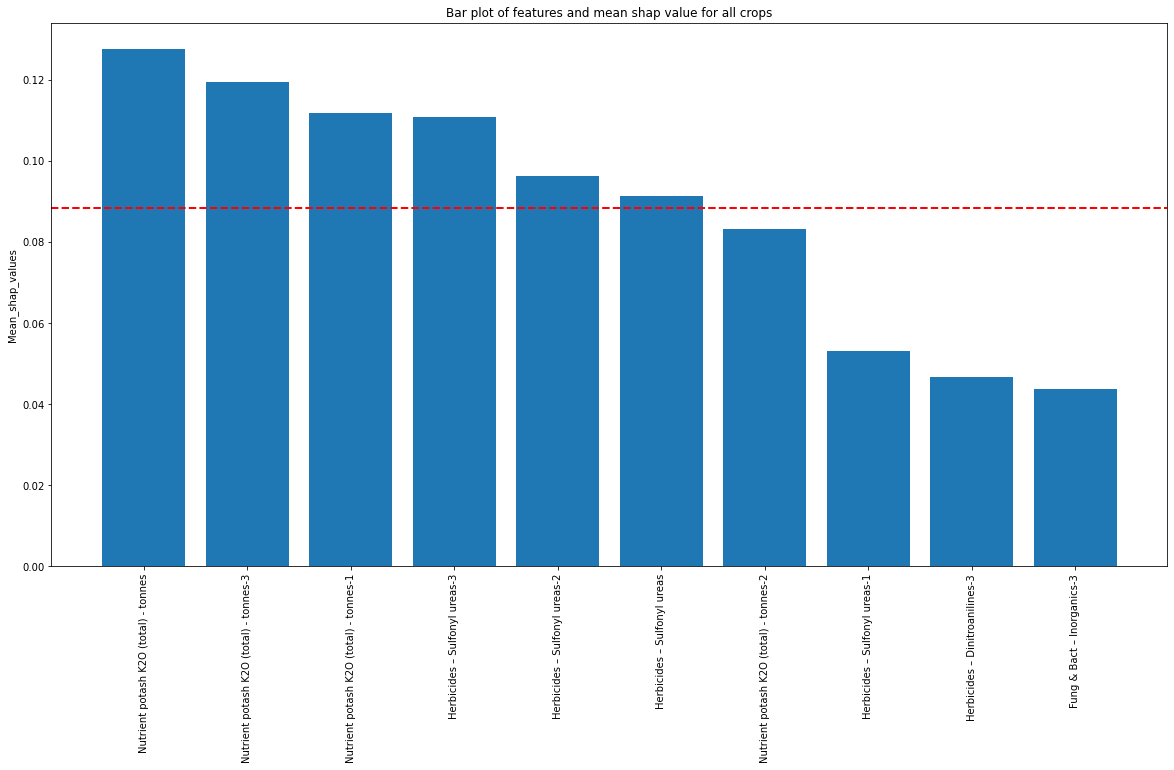

In [11]:
mean_shap = shap_df['mean_shap_value'].mean()
#sorted_df = shap_df.iloc[abs(shap_df['mean_shap_value']).argsort()]
# Select the top 10 rows
sorted_df = shap_df.reindex(shap_df['mean_shap_value'].abs().sort_values(ascending=False).index)
vals = list(fao_data["Crop_season"].unique())
vals.remove('Winter')
#vals.remove(np.nan)
vals.remove('Fall')


vals = vals + ["Yield(tonnes/ha)-3", "Yield(tonnes/ha)-2","Yield(tonnes/ha)-1"]
print(vals)
sorted_df2 = sorted_df.drop(vals, axis = 0)
top_10 = sorted_df2.head(10)

#sorted_means = sorted(mean_shap, key=abs, reverse=True)
#top_values = sorted_means[:10]
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(top_10.index, top_10['mean_shap_value'])
ax.axhline(top_10['mean_shap_value'].mean(), color='red', linestyle='dashed', linewidth=2)
ax.set_xticklabels(top_10.index, rotation=90)
ax.set_ylabel('Mean_shap_values')
ax.set_title('Bar plot of features and mean shap value for all crops')
plt.show()